#### Импортируем библиотеки и подключаем скрипты для работы

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

Matplotlib created a temporary config/cache directory at /var/folders/35/yj61spk56k3f7_3ycp2y103w0000gn/T/matplotlib-v68_p4tf because the default path (/Users/lmr/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Прописываем путь к файлам и данным, проводим анализ данных

In [4]:
TRAIN_DATASET_PATH = '/Users/lmr/Desktop/pythonDS/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/Users/lmr/Desktop/pythonDS/real-estate-price-prediction-moscow/test.csv'

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В столбцах LifeSquare и Healthcare_1 имеются пропуски. 

In [7]:
# приведение типов данных
train_df['Id'] = train_df['Id'].astype(str)

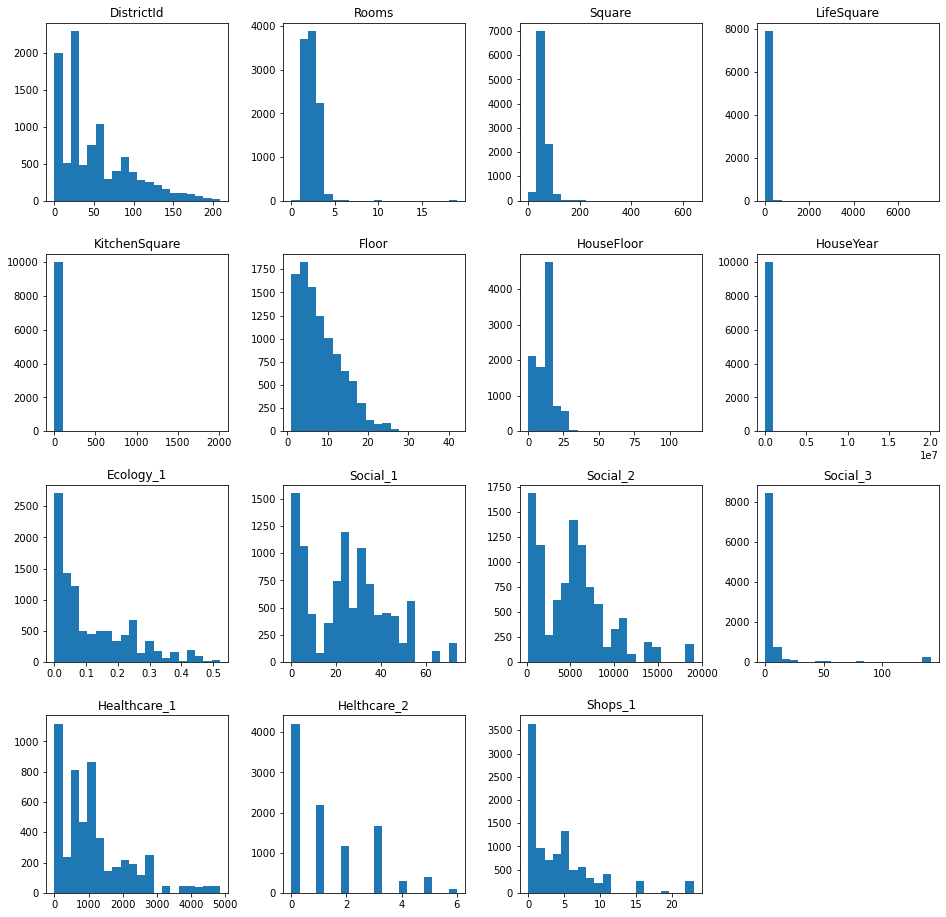

In [8]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [9]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Выбросы и аномалии содержатся в колонках HouseYear, KitchenSquare, HouseFloor, LifeSquare, Rooms, Square.

In [10]:
train_df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [11]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

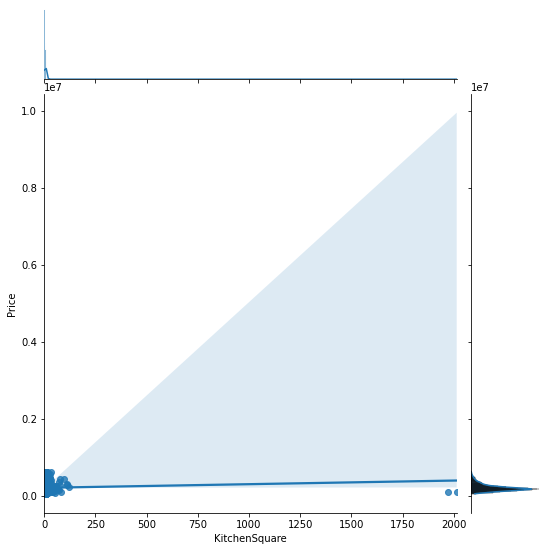

In [12]:
grid = sns.jointplot(train_df['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Ограничим значения для KitchenSquare до 200

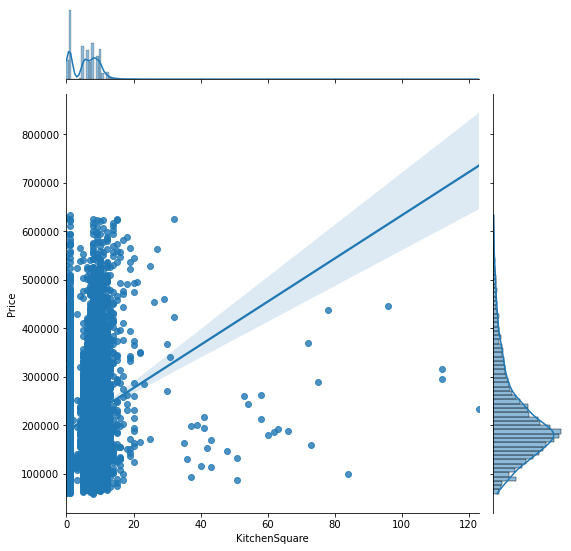

In [13]:
train_df_temp = train_df.loc[train_df['KitchenSquare']<200]
grid = sns.jointplot(train_df_temp['KitchenSquare'], train_df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Значения меньше 4х и больше 35 принимаем за выброс

In [14]:
train_df['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

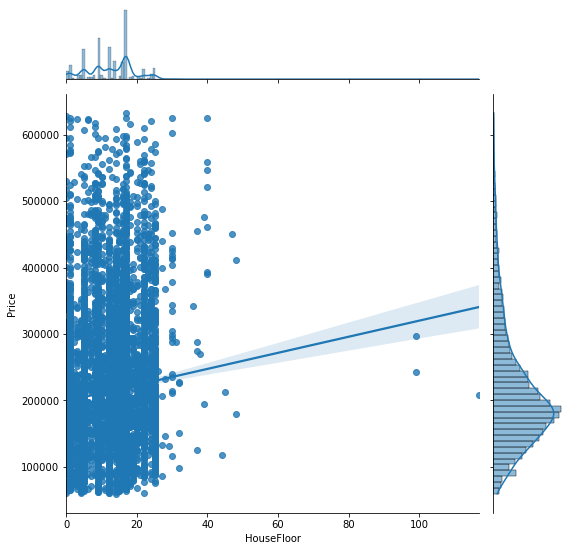

In [15]:
grid = sns.jointplot(train_df['HouseFloor'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Значения выше 50 примем за выброс

In [16]:
train_df['LifeSquare'].value_counts()

20.151696    1
28.241964    1
23.884805    1
51.826876    1
47.972602    1
            ..
45.455722    1
50.458505    1
42.172028    1
21.993610    1
27.598712    1
Name: LifeSquare, Length: 7887, dtype: int64

неинформативный список

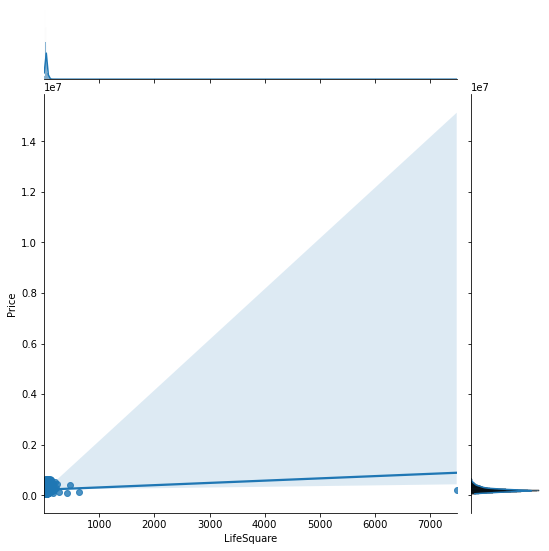

In [17]:
grid = sns.jointplot(train_df['LifeSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

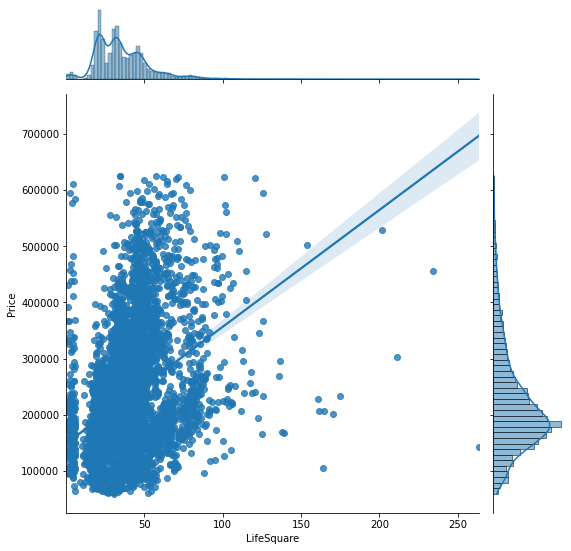

In [18]:
train_df_temp = train_df.loc[train_df['LifeSquare']<300]
grid = sns.jointplot(train_df_temp['LifeSquare'], train_df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

Значения меньше 8 и больше 250 примем за выброс

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [20]:
train_df['Square'].value_counts()

52.327165    1
34.785487    1
45.823093    1
57.607965    1
57.925603    1
            ..
60.776683    1
72.956943    1
51.770111    1
41.843220    1
64.226361    1
Name: Square, Length: 10000, dtype: int64

неинформативный список

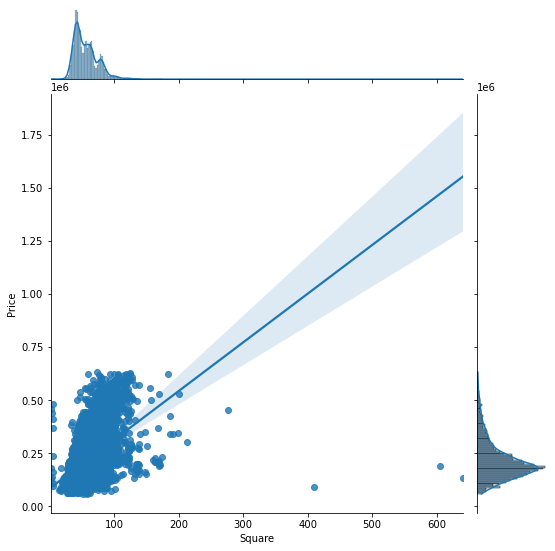

In [21]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

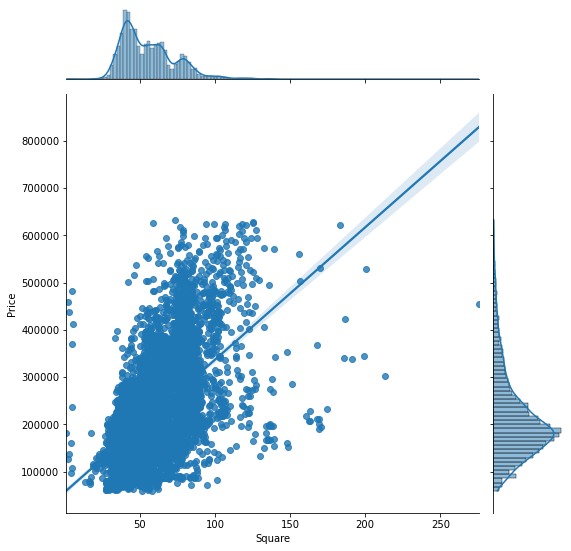

In [22]:
train_df_temp = train_df.loc[train_df['Square']<400]
grid = sns.jointplot(train_df_temp['Square'], train_df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

In [23]:
train_df.shape


(10000, 20)

In [24]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.shape

(5000, 19)

In [25]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


в обучающей выборке на один признак больше

#### Строим распределение целевой переменной

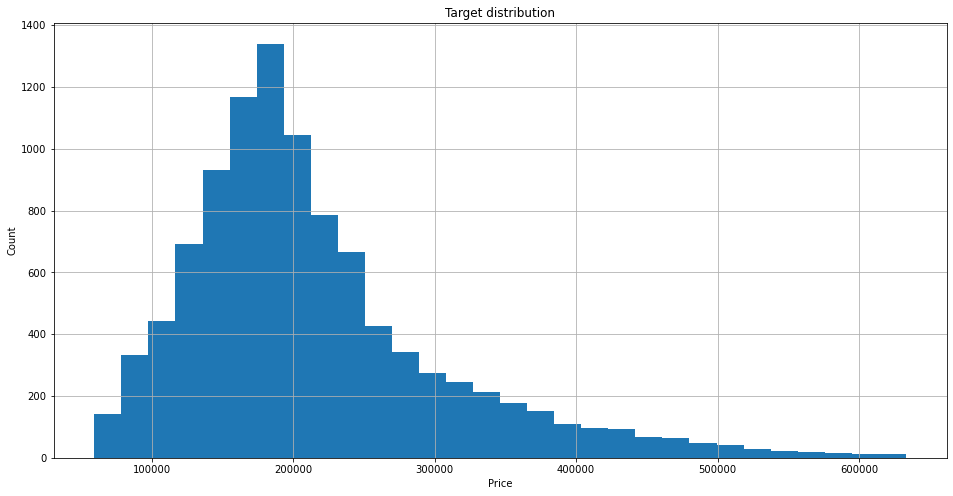

In [26]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

####  Выявим главный признак

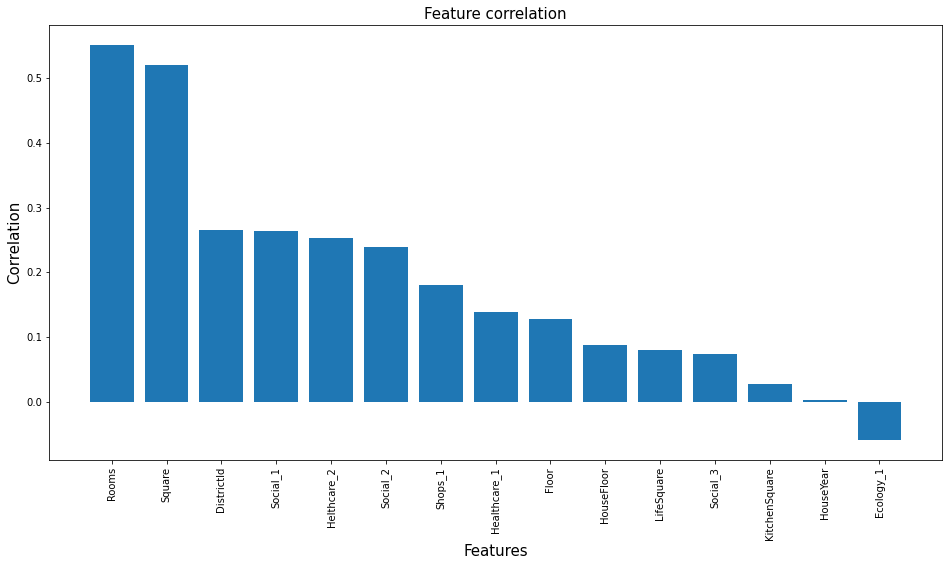

In [27]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

#### Зададим класс для подготовки и обработки данных

In [28]:
class Data:
    
    def __init__(self):
        """Задаем релятивные интервалы значений для обработки выбросов на основе анализа данных"""
        self.Square_min = 20
        self.Square_max = 300
        
        self.LifeSquare_min = 8
        self.LifeSquare_max = 250
        
        self.Rooms_min = 1
        self.Rooms_max = 6
        
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        
        self.KitchenSquare_min = 4
        self.KitchenSquare_max = 35
        
        self.current_year = datetime.now().year
        
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
        
        
    def fit(self, train_df):
        
        # медианы
        self.medians = train_df[['LifeSquare', 'Healthcare_1']].median()
        
        # подсчет популярных районов
        self.DistrictId_value_counts = dict(train_df['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        train_df_temp = train_df.loc[((train_df['Square'] > self.Square_min) & (train_df['Square'] < self.Square_max))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del train_df_temp
        
    def transform(self, train_df):
        
        # Обработка пропусков
        train_df[['LifeSquare', 'Healthcare_1']] = train_df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        # Обработка выбросов
        
        # площадь
        train_df.loc[(train_df['Square'] > self.Square_max), 'Square'] = self.Square_max
        train_df.loc[(train_df['Square'] < self.Square_min), 'Square'] = self.Square_min
        
        # жилая площадь
        train_df.loc[(train_df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        train_df.loc[(train_df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        
        # площадь кухни
        train_df.loc[(train_df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        train_df.loc[(train_df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # год постройки дома
        train_df.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # количество комнат
        train_df.loc[(train_df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        train_df.loc[(train_df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        
        # количество этажей
        train_df.loc[(train_df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        train_df.loc[(train_df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # если этаж больше этажности дома, то присваиваем случайный этаж от self.HouseFloor_min до максимального этажа в доме
        floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        # Обработка категорий
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return train_df
    
    def features(self, train_df):
        
        # добавление признака популярности района
        train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        
        # добавление признака средней стоимости м2 по району
        train_df = train_df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageSquareMeterPrice'].fillna(train_df['AverageSquareMeterPrice'].median(), inplace=True)
        
        # добавление признака среднего значения Healthcare_1 по району
        train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return train_df

#### Инициализация класса Data

In [29]:
data_inst = Data()

# тренировочные данные
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)

# тестовые данные
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

Задаем список признаков для модели

In [30]:
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [31]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names + ['Id']]
X = train_df[feature_names]
y = train_df[target_name]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

#### Обучение модели

In [33]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=100, n_estimators=500,
                      n_jobs=-1, random_state=39)

Train R2:	0.772
Test R2:	0.748


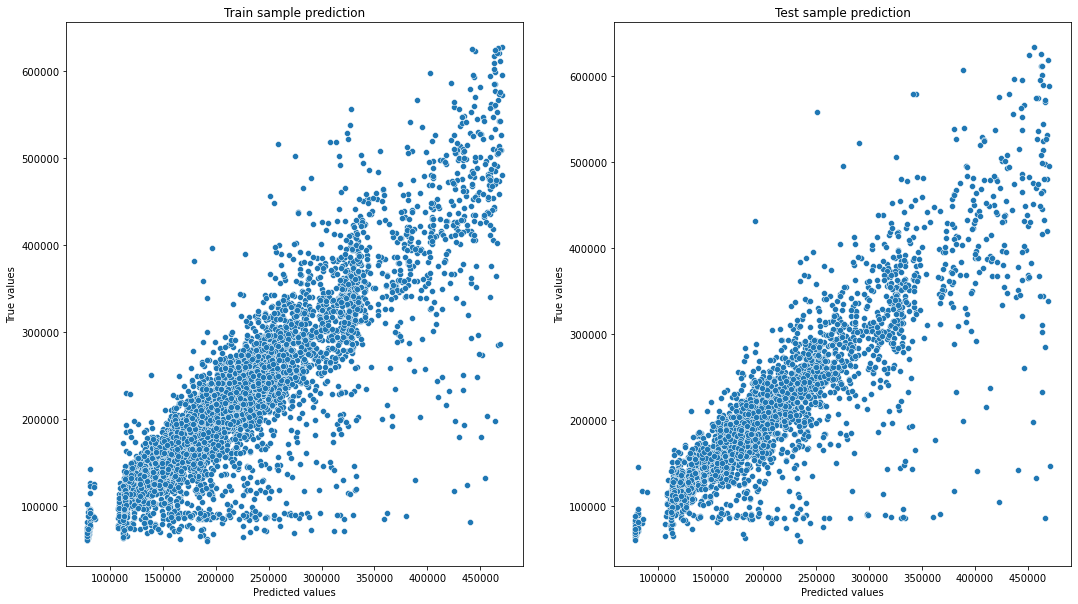

In [34]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [35]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.75592171, 0.73563026, 0.71086711, 0.73242234, 0.76012663])

In [36]:
print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.739


Оценка признаков

In [37]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.497008
0,AverageSquareMeterPrice,0.416773
2,Rooms,0.032502
12,Social_2,0.009178
11,Social_1,0.007606
4,LifeSquare,0.005843
5,KitchenSquare,0.004523
7,HouseFloor,0.004152
21,AverageHealthcare_1,0.004098
8,HouseYear,0.003871


#### Создание файла с прогнозом

In [47]:
submission_df = pd.read_csv('/Users/lmr/Desktop/pythonDS/real-estate-price-prediction-moscow/sample_submission.csv')
submission_df.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [48]:
y_pred_final = rf_model.predict(test_df)

submission_df['Price'] = y_pred_final
submission_df.head()

,Id,Price
0,4567,166992.104830
1,5925,122172.507470
2,960,154599.492412
3,3848,145453.249202
4,746,172069.613903


In [50]:
submission_df.shape

(5000, 2)

In [51]:
submission_df.to_csv('./rf_model_prediction.csv', index=False)